# How to continue a finished WorkTree

## Introduction
`WorkTree` supports adding new nodes to a already finished WorkTree and continue the submitting the jobs. WorkTree save its data as a extra attribute into its process, so that one can rebuild the WorkTree from the process.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## Create a `add_multiply` WorkTree

In [2]:
from aiida_worktree import node
from aiida.engine import calcfunction

# define add node
@node()
@calcfunction
def add(x, y):
    return x + y

# define multiply node
@node()
@calcfunction
def multiply(x, y):
    return x*y

from aiida_worktree import WorkTree
from aiida.orm import Int
x = Int(2.0)
y = Int(3.0)
z = Int(4.0)

wt = WorkTree("first_workflow")
wt.nodes.new(add, name="add1", x=x, y=y)
wt.nodes.new(multiply, name="multiply1", y=z)
wt.links.new(wt.nodes["add1"].outputs[0], wt.nodes["multiply1"].inputs["x"])

wt.submit(wait=True)

## Load the old WorkTree and add new nodes
Now, we want to add a new `add` node, and use the results from previous `add1` and `multiply1` nodes. Use the `load` method to load a WorkTree from a process.

In [3]:
from aiida_worktree import WorkTree
pk = wt.pk
wt2 = WorkTree.load(pk)
wt2.nodes.new(add, name="add2")
wt2.links.new(wt2.nodes["add1"].outputs[0], wt2.nodes["add2"].inputs["x"])
wt2.links.new(wt2.nodes["multiply1"].outputs[0], wt2.nodes["add2"].inputs["y"])
wt2.submit(wait=True)

### Check status and results


In [6]:
print("State of WorkTree   : {}".format(wt2.state))
print('Result of add1      : {}'.format(wt.nodes["add1"].node.outputs.result.value))
print('Result of multiply1 : {}'.format(wt.nodes["multiply1"].node.outputs.result.value))
print('Result of add2      : {}'.format(wt2.nodes["add2"].node.outputs.result.value))

State of WorkTree   : FINISHED
Result of add1      : 5
Result of multiply1 : 20
Result of add2      : 25


Generate node graph from the AiiDA process:

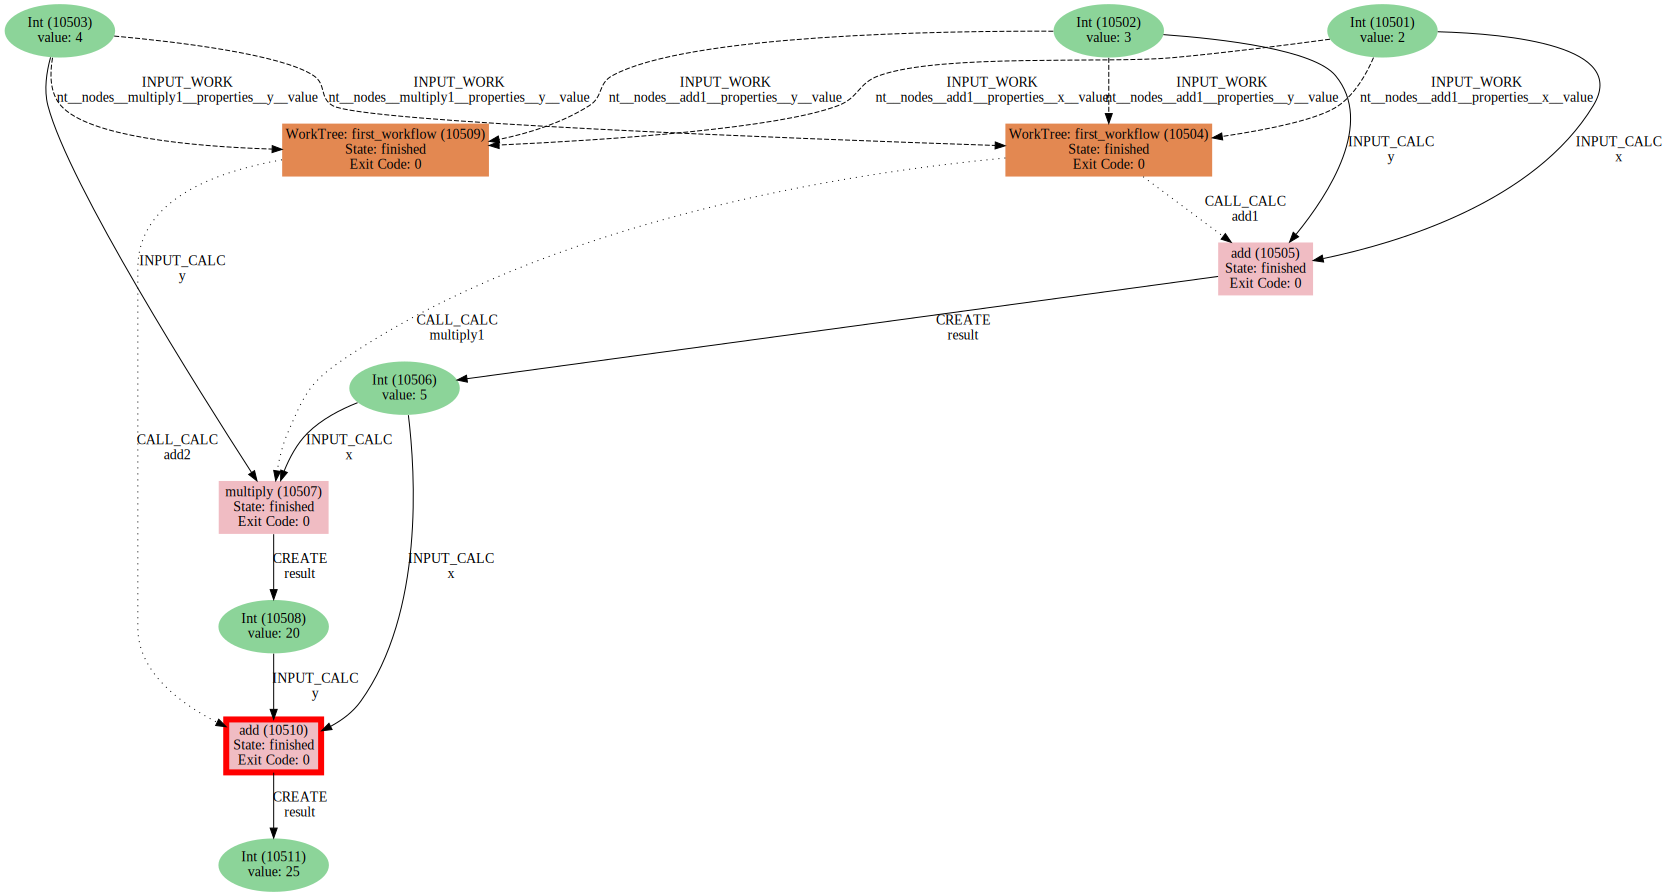

In [9]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt2.nodes['add2'].pk)

The provenance graph of the WorkTree is still keeped in the AiiDA database.